In [29]:
# ============================================
# || import all necessary libraries         ||
# ============================================

import numpy as np
import matplotlib.pyplot as plt
import random
import time
from typing import Dict, List, Tuple, Any
import sys
import os

# Utilities
from utils.data import get_fixed_data
from utils.visualization import plot_results, plot_experiment_results, plot_cost_histogram, compare_policies

# Task 0
## Liv har code som er brugt til de to scenarier

Optimal cost: 339.0


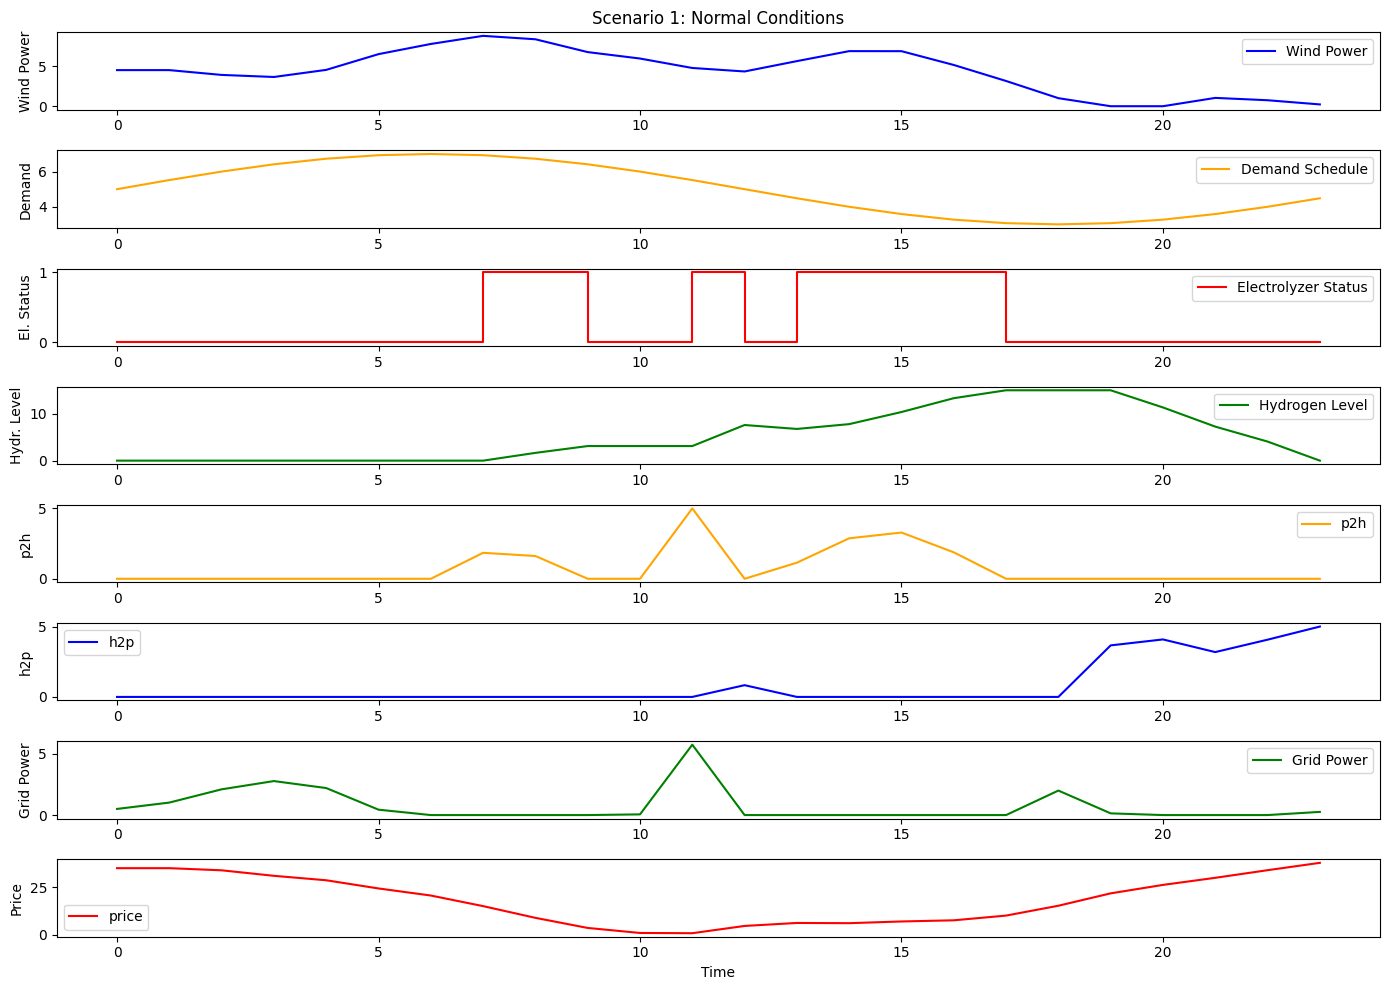

Optimal cost: 0.0


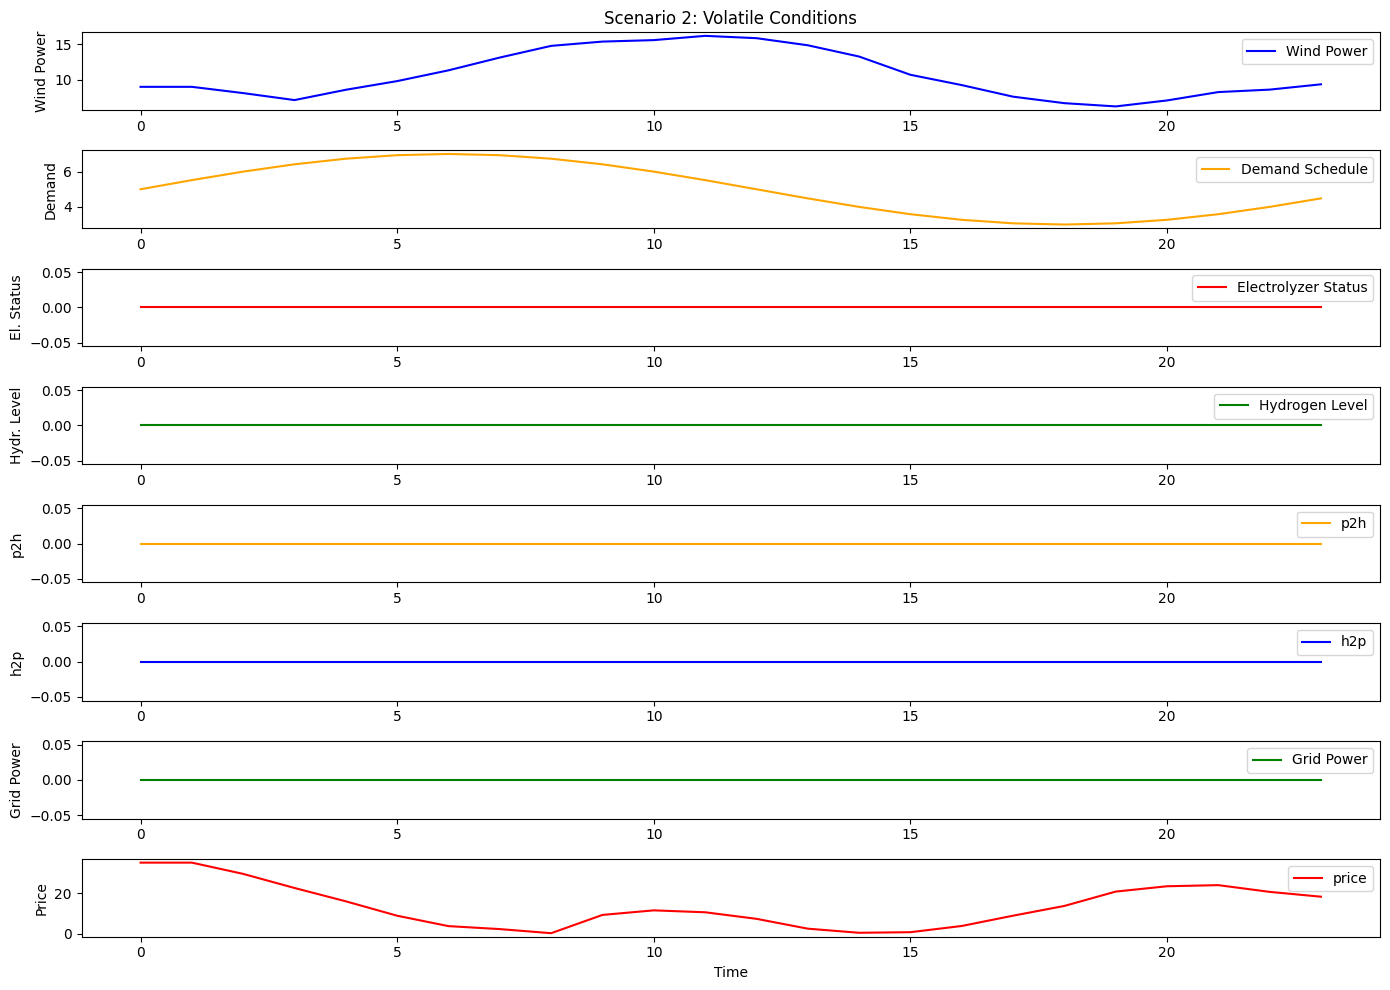

In [7]:
from task_0.helper_functions import generate_trajectories, solve_milp

def main() -> None:
    data = get_fixed_data()
    
    # First scenario - Normal conditions
    wind1, price1 = generate_trajectories(data)
    results1 = solve_milp(wind1, price1, data, False)
    plot_results(wind1, price1, results1, data, "Scenario 1: Normal Conditions")

    # Second scenario - More volatile conditions?
    data_volatile = data.copy()
    data_volatile['target_mean_wind'] = data_volatile['target_mean_wind']*2
    data_volatile['price_reversion_strength'] = data_volatile['price_reversion_strength']*2

    wind2, price2 = generate_trajectories(data_volatile)
    results2 = solve_milp(wind2, price2, data, False)
    plot_results(wind2, price2, results2, data, "Scenario 2: Volatile Conditions")
random.seed(42)
main()

# Task 1

ENERGY HUB MDP EVALUATION

Evaluating Dummy Policy over 20 experiments...
Processing experiment 0...
Processing experiment 5...
Processing experiment 10...
Processing experiment 15...
Average policy cost: 615.66
Min cost: 180.97, Max cost: 1271.83
Dummy Policy Results:
Average Cost: 615.66
Min Cost: 180.97
Max Cost: 1271.83
Evaluation Time: 1.01 seconds

Generating visualizations...

Generating visualizations for Dummy Policy...


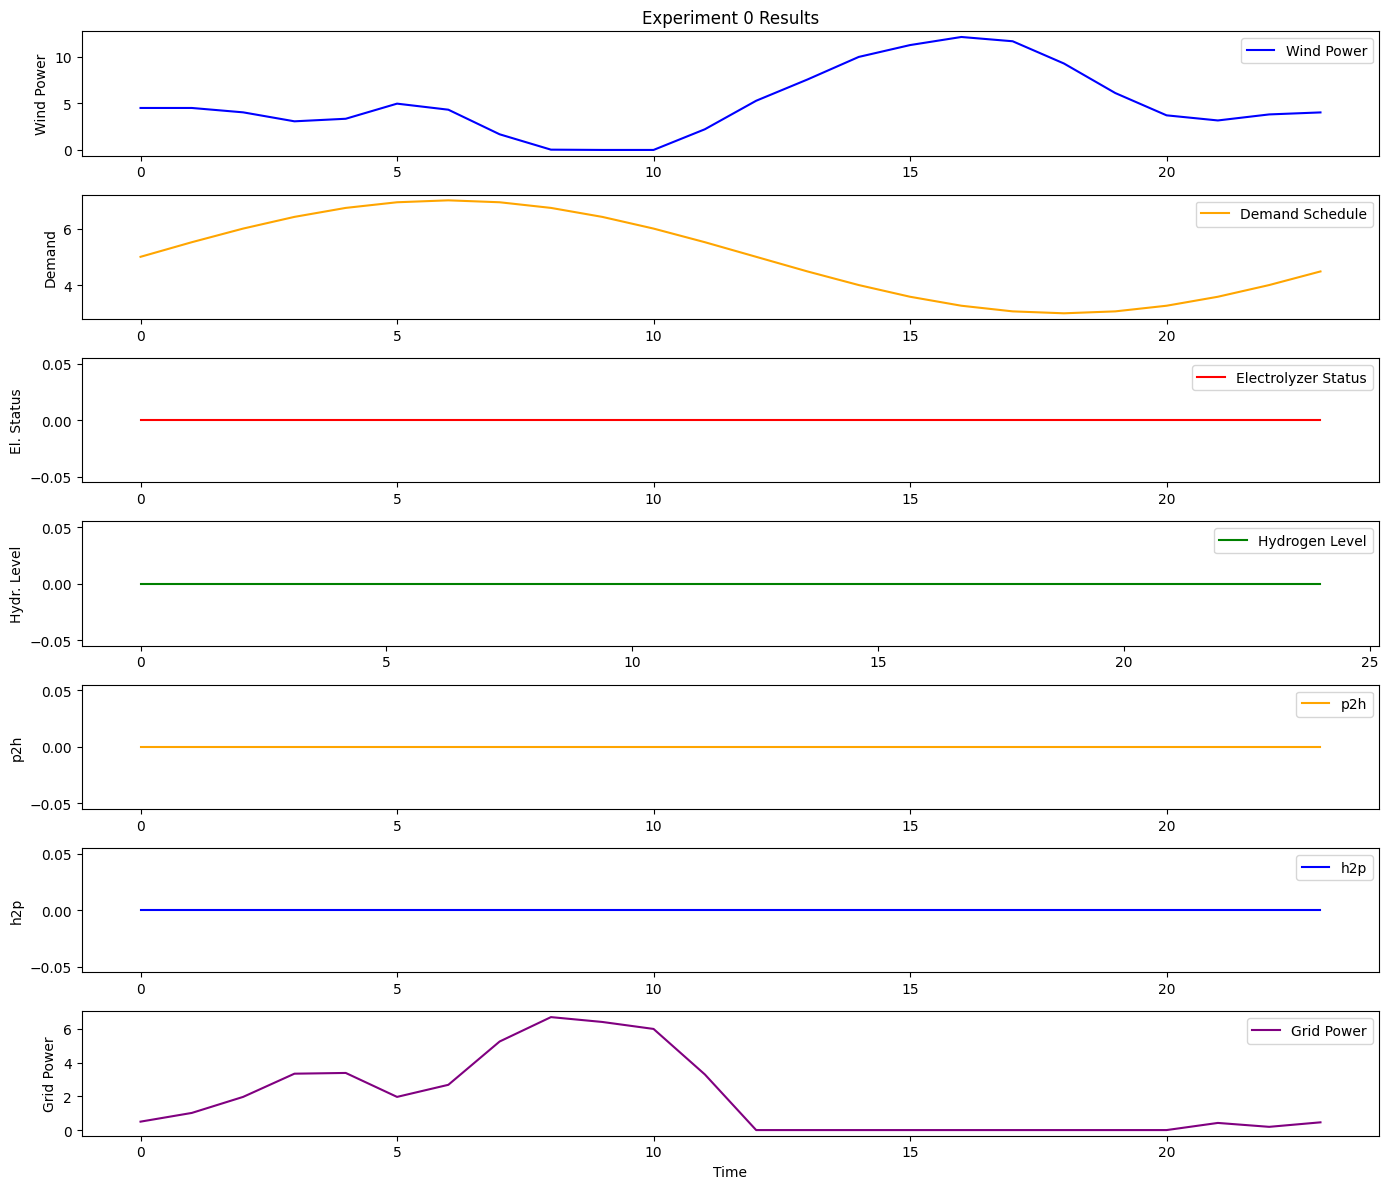

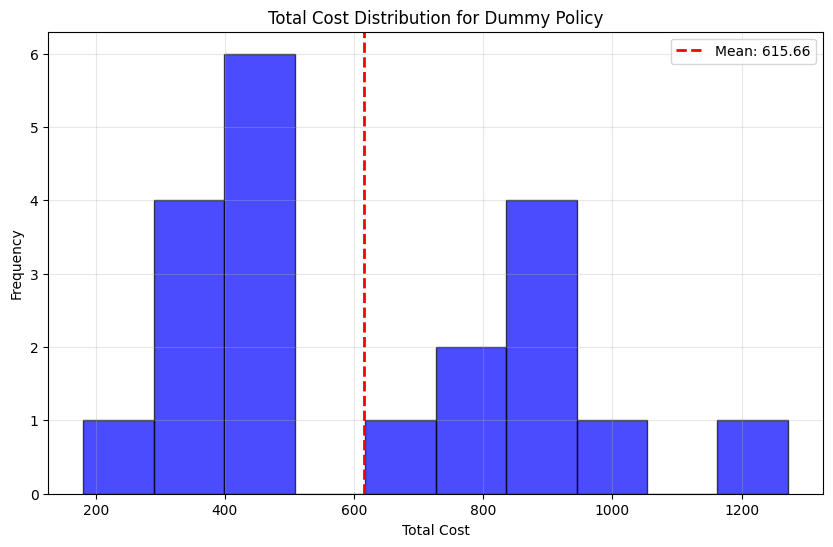

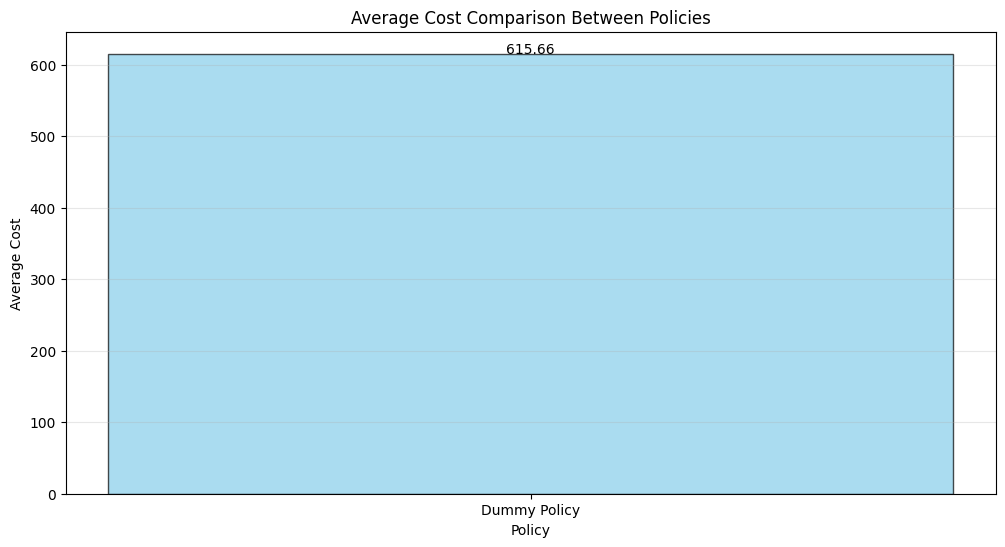


Evaluation completed successfully!


In [5]:
from task_1.evaluation_framework import evaluate_policy
from task_1.energy_hub_policies import dummy_policy
def main():
    data = get_fixed_data()
    
    print("=" * 50)
    print("ENERGY HUB MDP EVALUATION")
    print("=" * 50)
    num_experiments = 20
    policy_results = {}
    policies = {
        "Dummy Policy": dummy_policy
    }
    
    # Evaluate each policy
    for policy_name, policy_func in policies.items():
        print(f"\nEvaluating {policy_name} over {num_experiments} experiments...")
        start_time = time.time()
        
        avg_cost, results = evaluate_policy(policy_func, num_experiments=num_experiments)
        
        elapsed_time = time.time() - start_time
        
        print(f"{policy_name} Results:")
        print(f"Average Cost: {avg_cost:.2f}")
        print(f"Min Cost: {np.min(results['total_costs']):.2f}")
        print(f"Max Cost: {np.max(results['total_costs']):.2f}")
        print(f"Evaluation Time: {elapsed_time:.2f} seconds")
        
        # Store the results
        policy_results[policy_name] = results
    
    print("\nGenerating visualizations...")
    
    for policy_name, results in policy_results.items():
        print(f"\nGenerating visualizations for {policy_name}...")
        
        plot_experiment_results(results, experiment_index=0, data=data) # just the first experiment
        
        plot_cost_histogram(results, policy_name=policy_name) # histogram of total costs over all experiments
    
    # Compare all policies for next task
    compare_policies(policy_results)
    
    print("\nEvaluation completed successfully!")
    
    return policy_results

if __name__ == "__main__":
    policy_results = main()

# Task 2

TASK 2: STOCHASTIC PROGRAMMING POLICIES FOR ENERGY HUB MANAGEMENT

--------------------------------------------------
Evaluating: Dummy Policy
--------------------------------------------------
Processing experiment 0...
Processing experiment 5...
Processing experiment 10...
Processing experiment 15...
Average policy cost: 745.49
Min cost: 87.12, Max cost: 1388.34

Results for Dummy Policy:
Average Cost: 745.49
Min Cost: 87.12
Max Cost: 1388.34
Standard Deviation: 347.51
Evaluation Time: 0.00 seconds

--------------------------------------------------
Evaluating: Expected Value Policy (Horizon=3)
--------------------------------------------------
Processing experiment 0...
Power balance constraint violated: 5.517638087272644 < 5.5176380902050415
DECISION DOES NOT MEET THE CONSTRAINTS FOR EXPERIMENT 0, TIMESLOT 1. THE DUMMY POLICY WILL BE USED INSTEAD
Power balance constraint violated: 3.999999993550934 < 4.0
DECISION DOES NOT MEET THE CONSTRAINTS FOR EXPERIMENT 0, TIMESLOT 14. THE DUMM

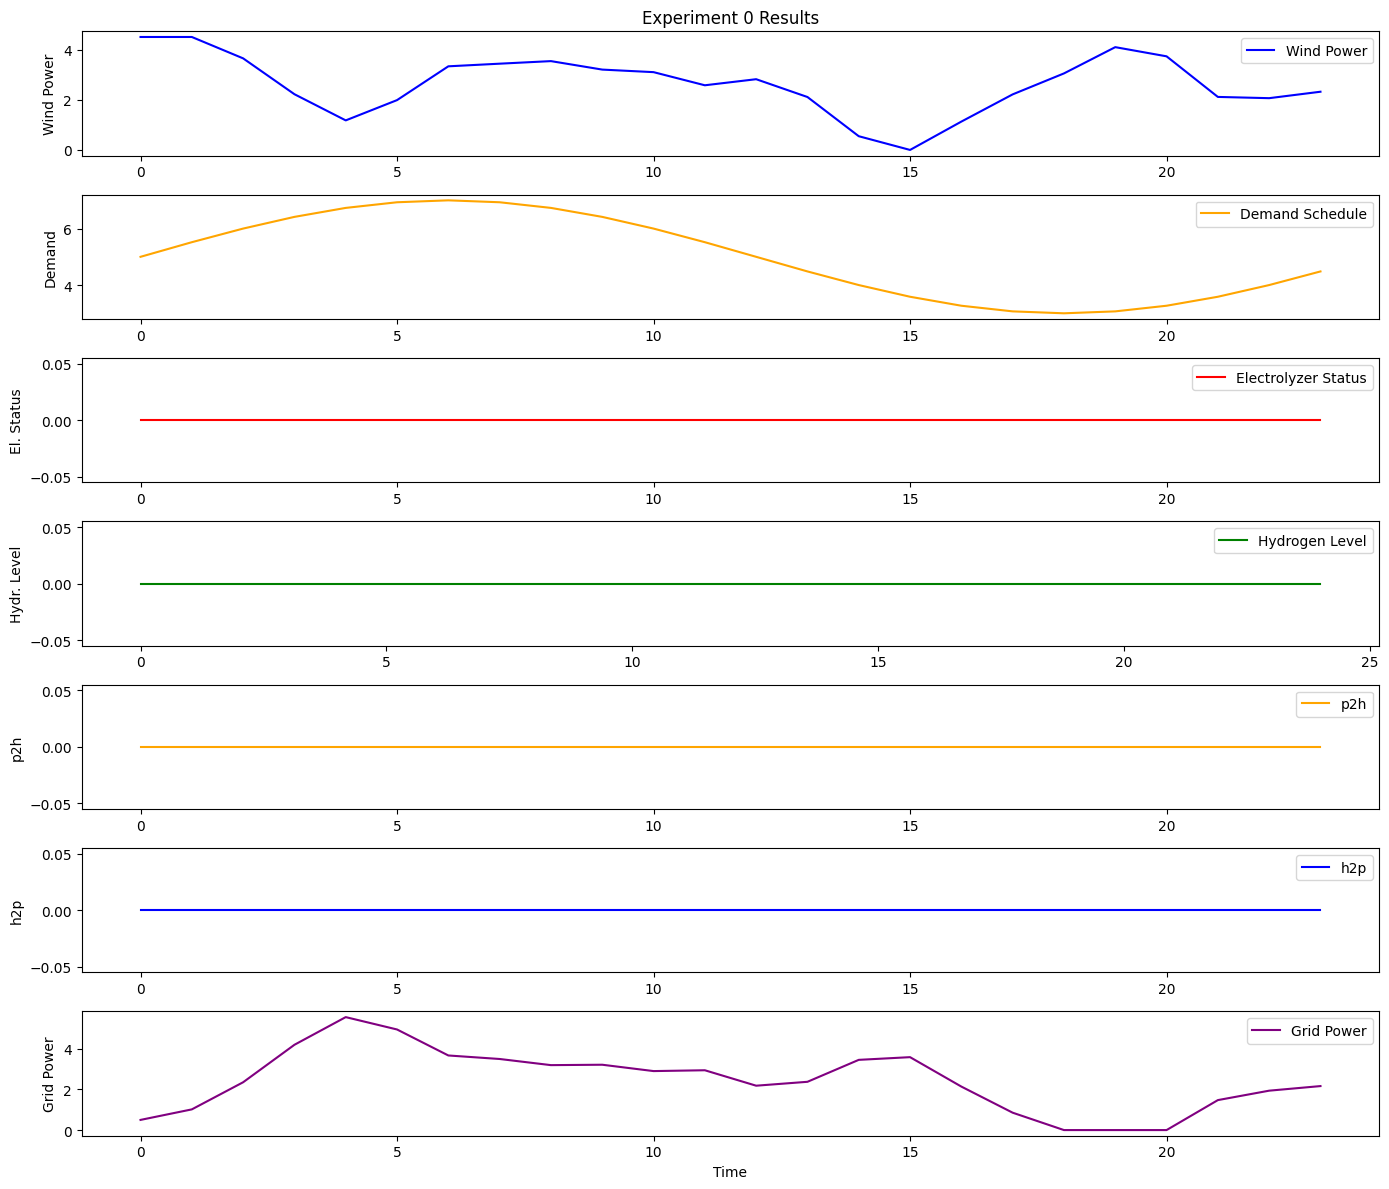

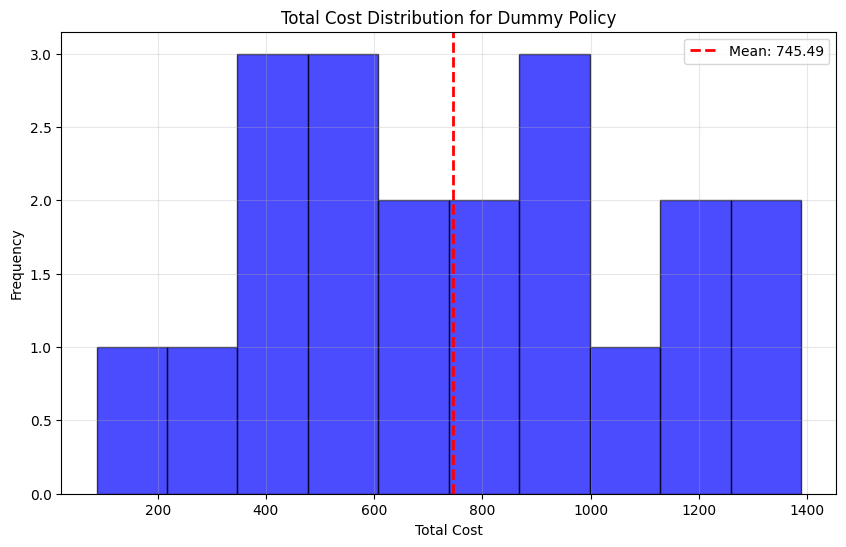


Visualizing results for Expected Value Policy (Horizon=3)...


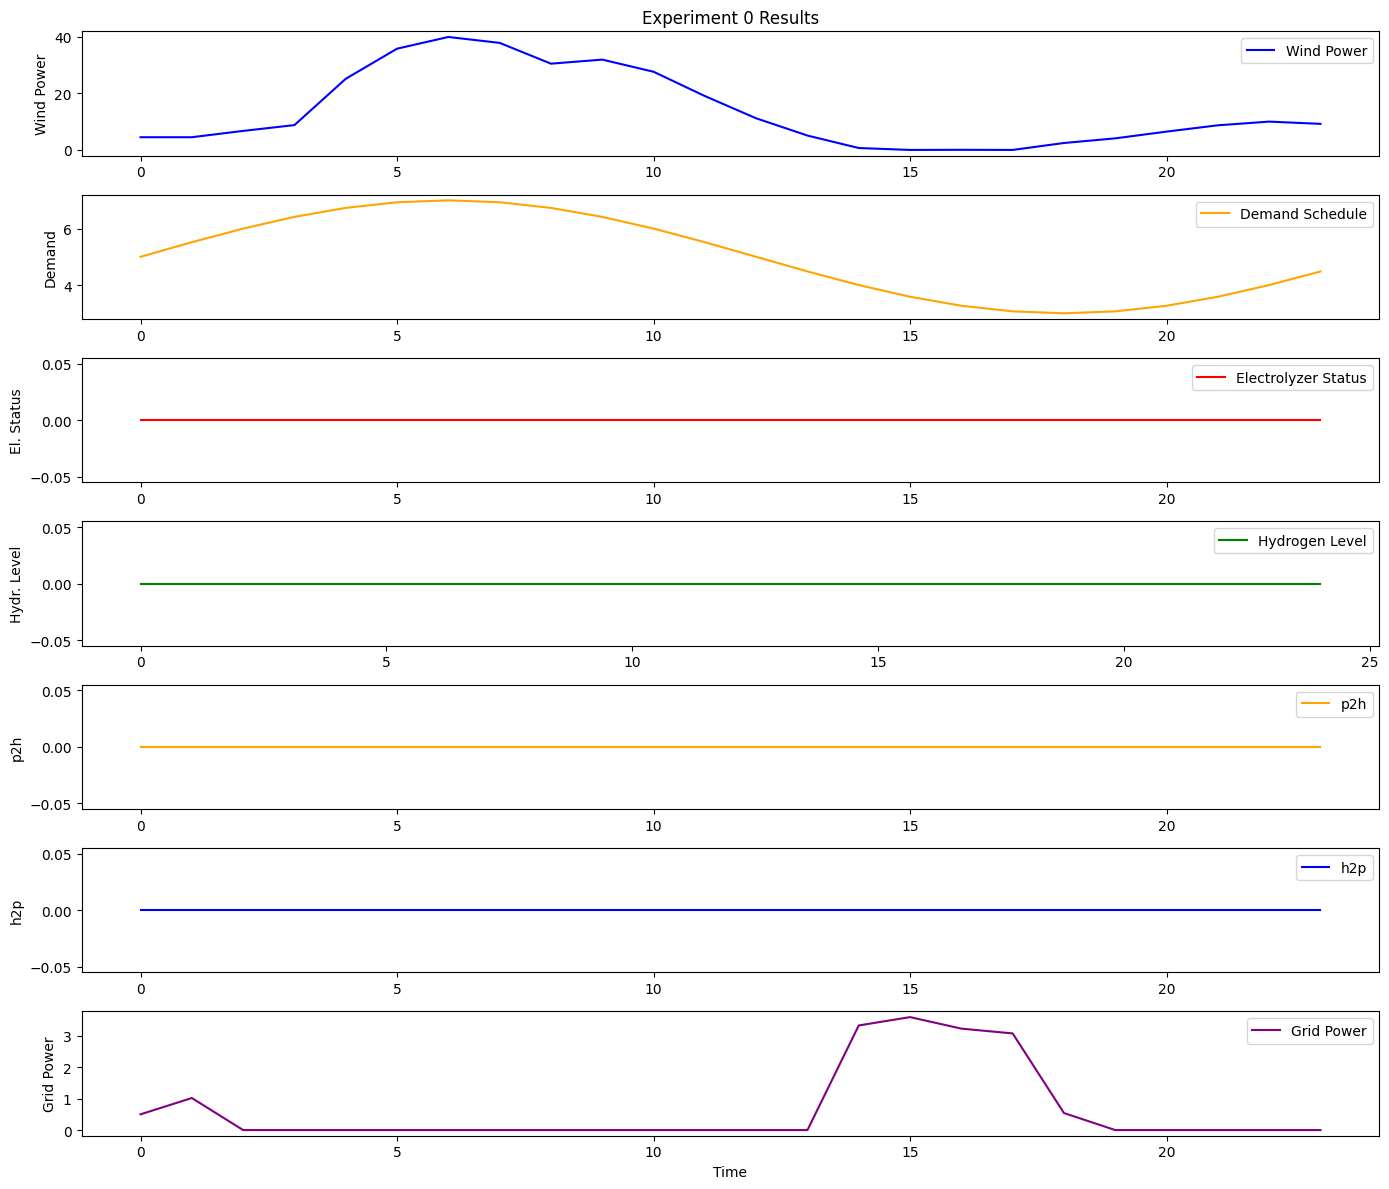

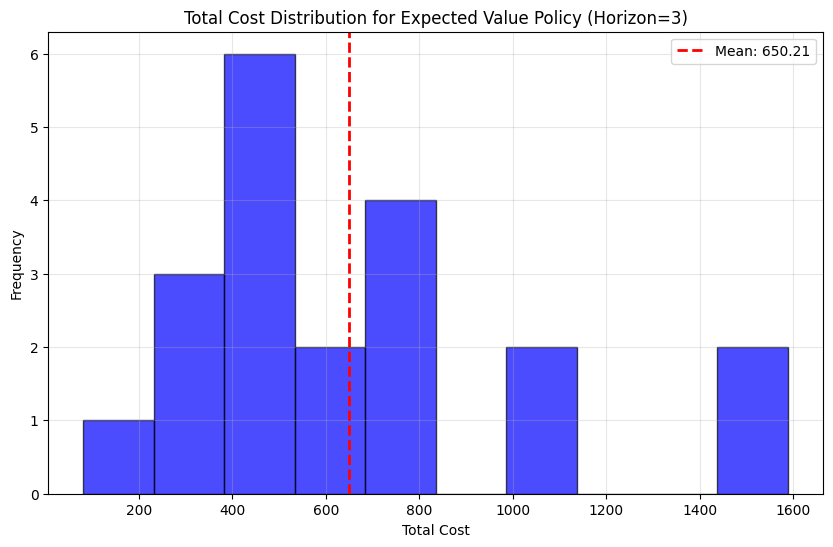


Visualizing results for SP Policy (Horizon=2, Scenarios=10)...


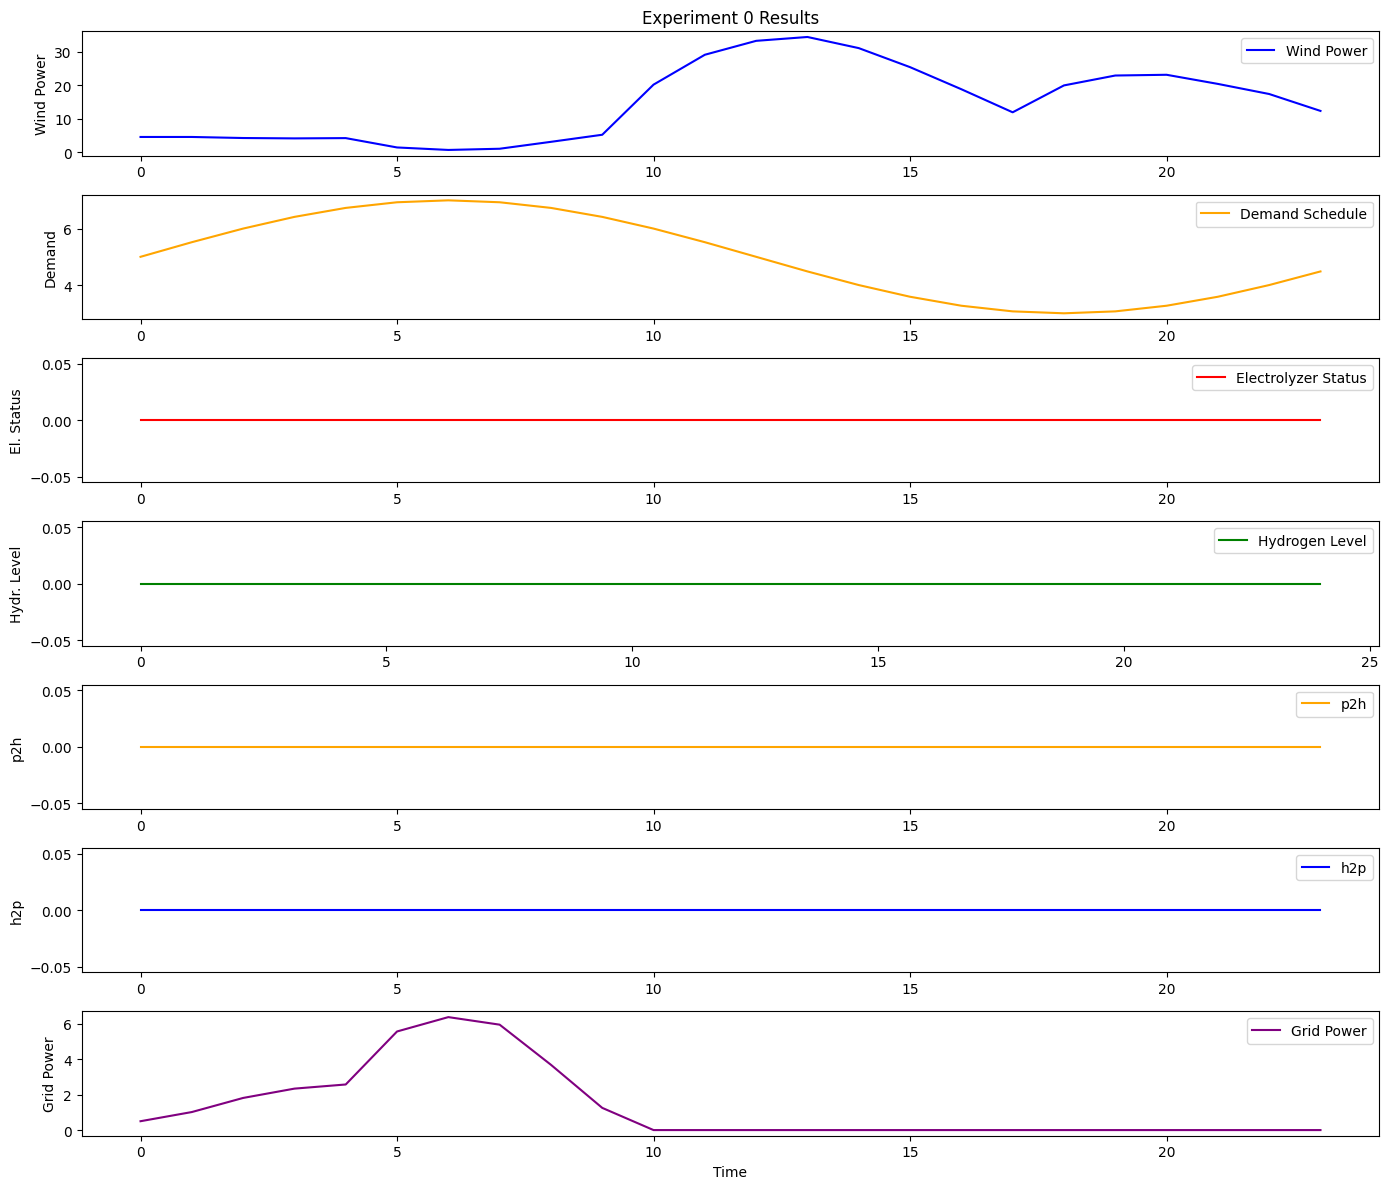

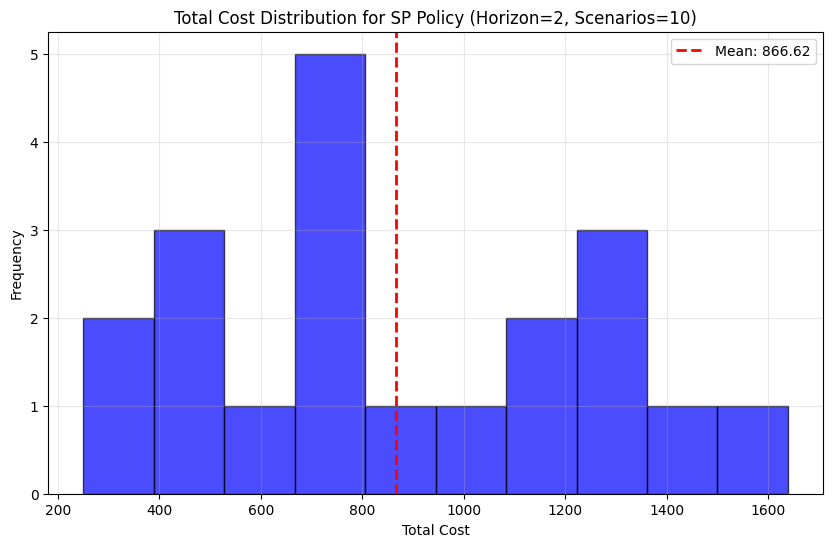


Visualizing results for SP Policy (Horizon=3, Scenarios=6)...


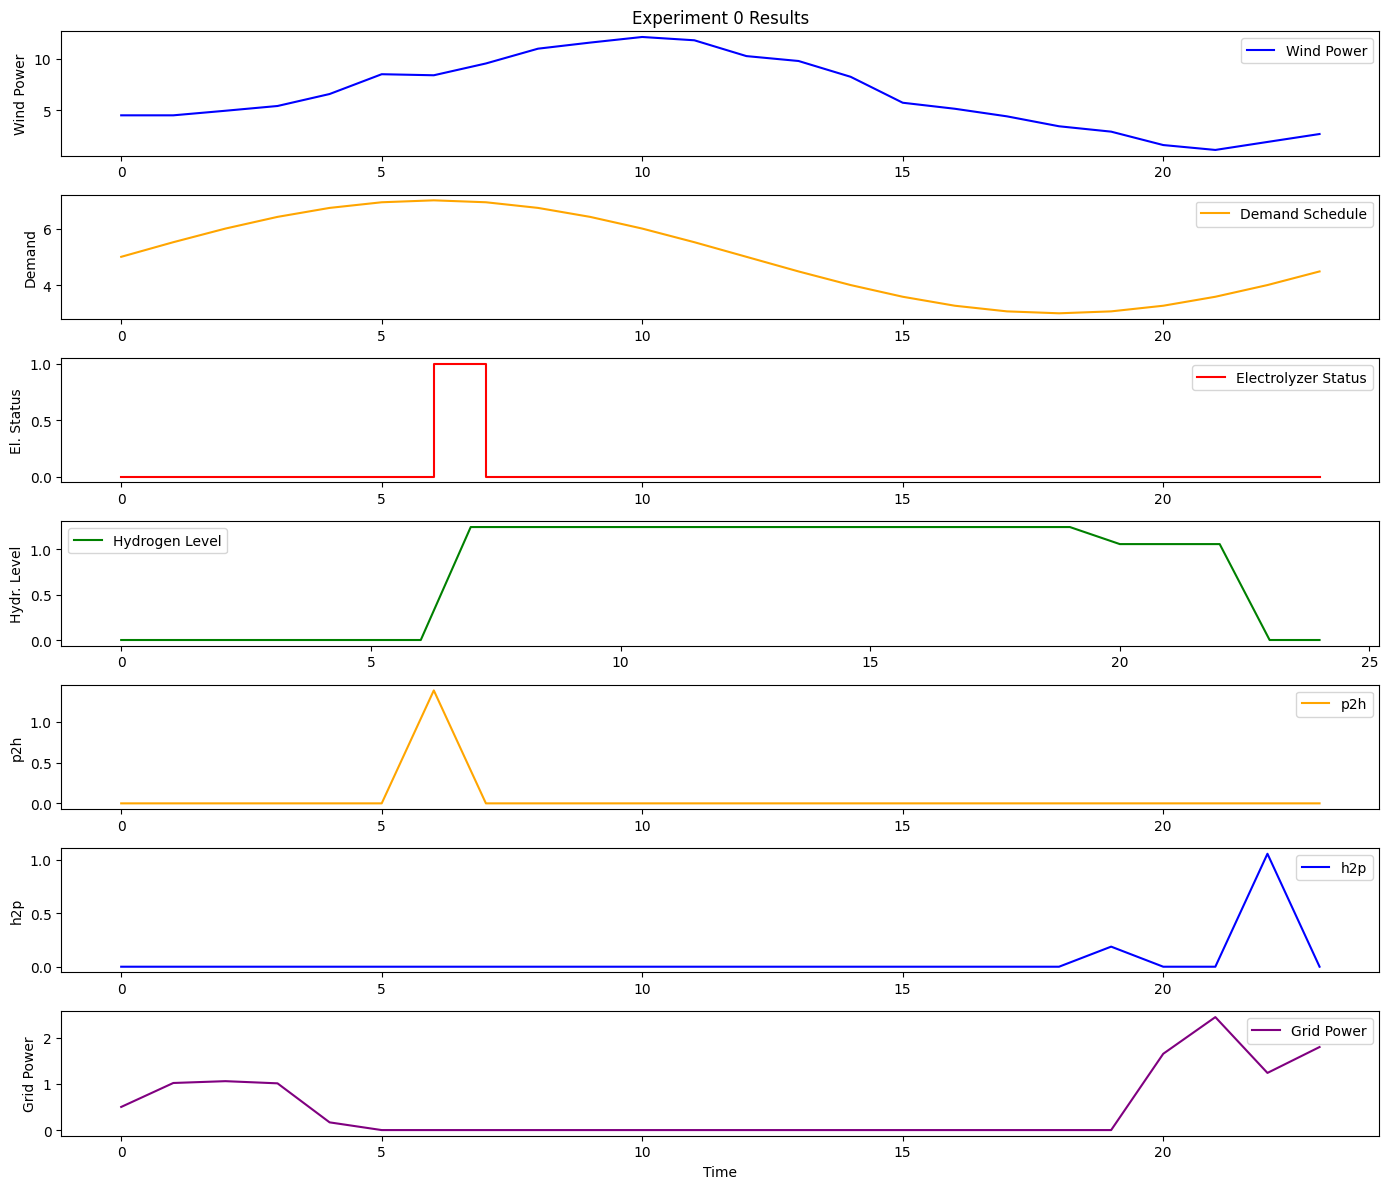

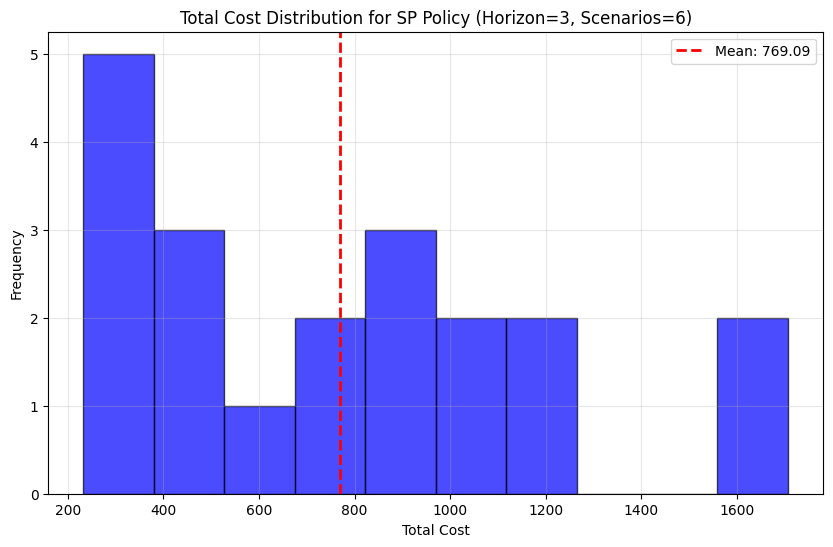


Visualizing results for SP Policy (Horizon=5, Scenarios=4)...


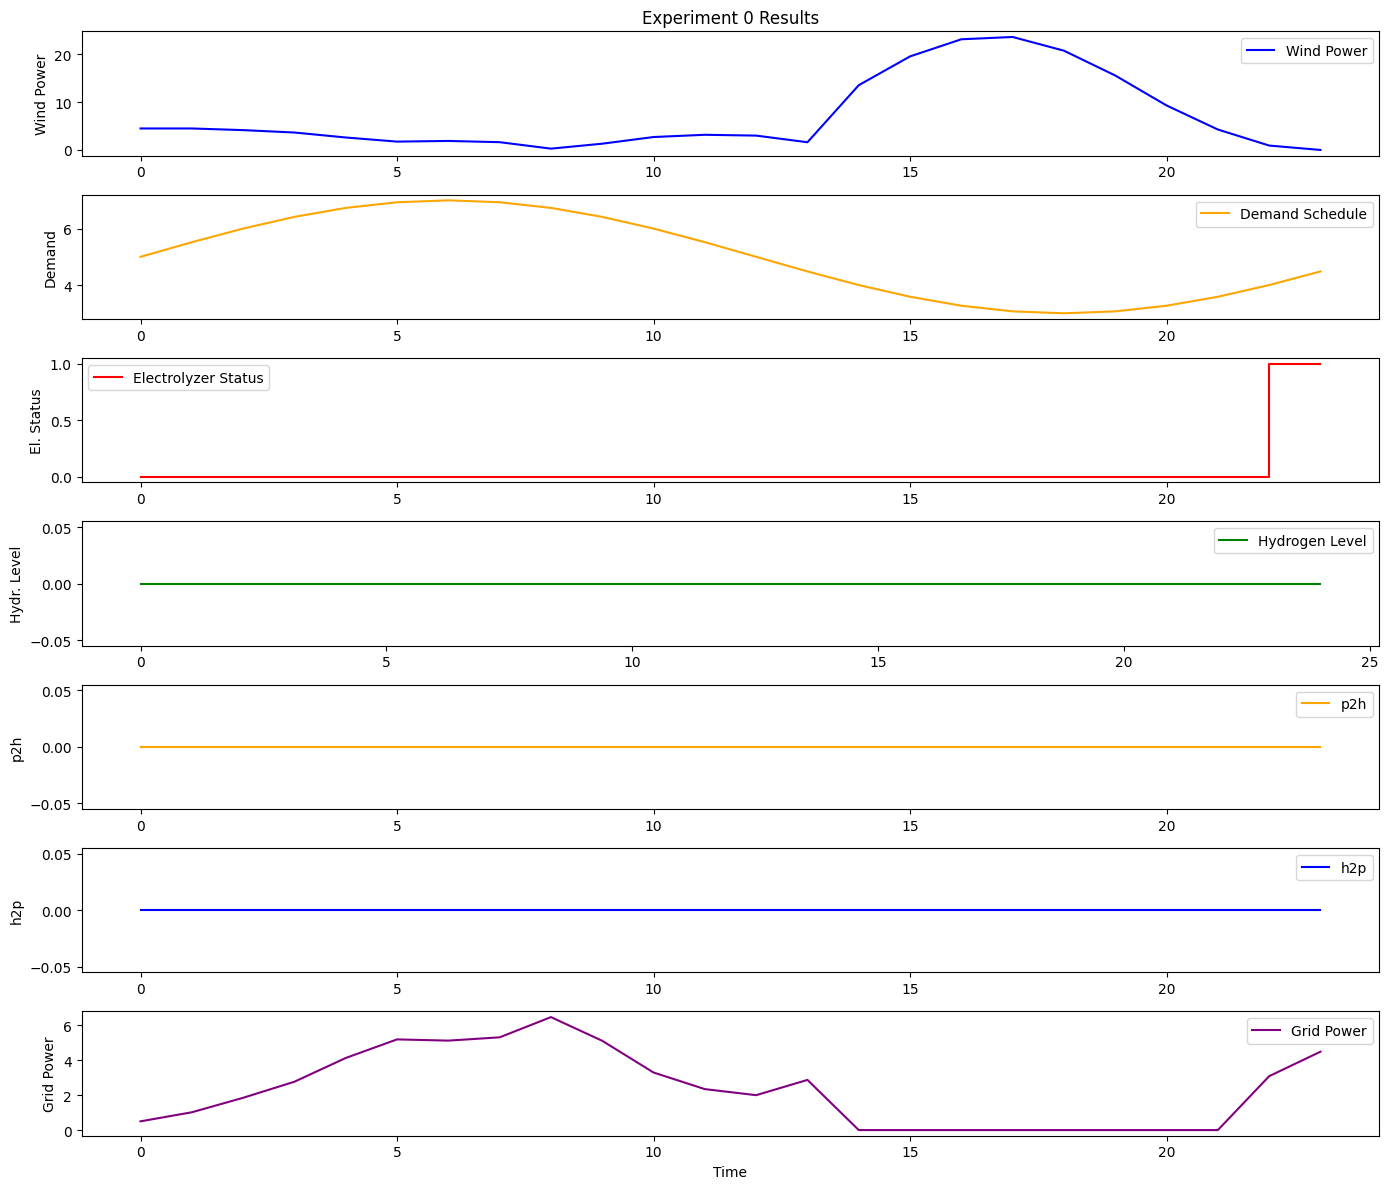

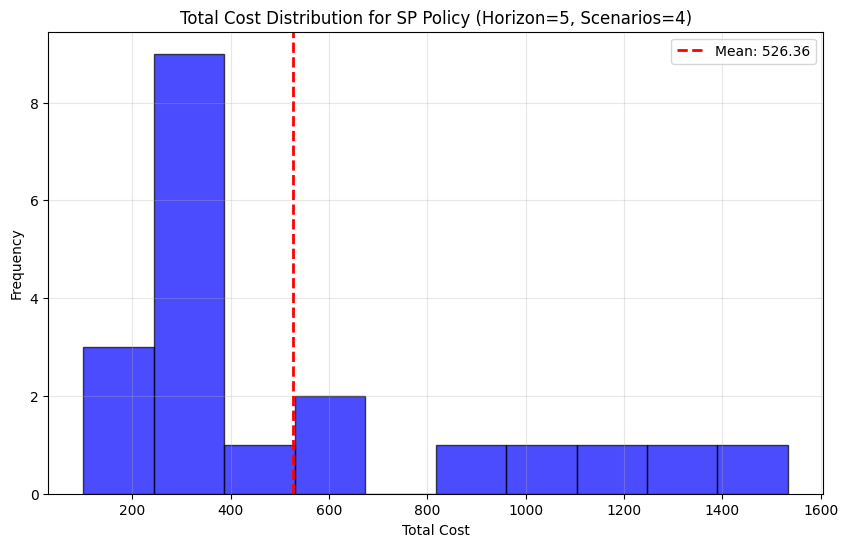


Generating comparison across all policies...


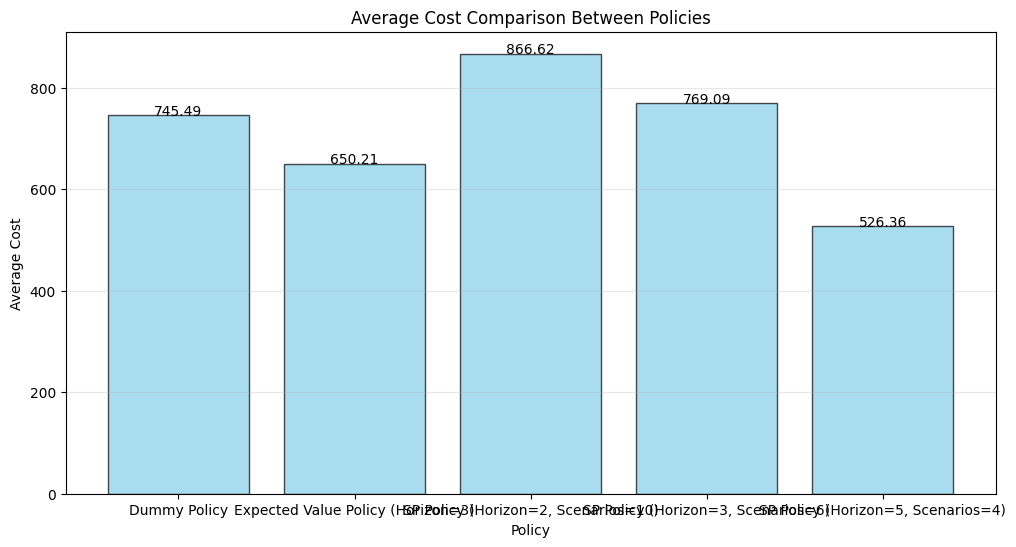


Task 2 evaluation completed successfully!


In [ ]:
# Import framework components
from task_2.helper_functions import (
    sp_policy_short_horizon,
    sp_policy_medium,
    sp_policy_long_horizon,
    ev_policy
)

def main():
    """
    Main function to run Task 2 evaluation.
    """
    data = get_fixed_data()
    
    print("=" * 70)
    print("TASK 2: STOCHASTIC PROGRAMMING POLICIES FOR ENERGY HUB MANAGEMENT")
    print("=" * 70)
    
    # Number of experiments to run for each policy
    num_experiments = 20
    
    # Dictionary to store results for all policies
    policy_results = {}
    
    # Define the policies to evaluate
    policies = {
        "Dummy Policy": dummy_policy,
        "Expected Value Policy (Horizon=3)": ev_policy,
        "SP Policy (Horizon=2, Scenarios=10)": sp_policy_short_horizon,
        "SP Policy (Horizon=3, Scenarios=6)": sp_policy_medium,
        "SP Policy (Horizon=5, Scenarios=4)": sp_policy_long_horizon,
    }
    
    # Evaluate each policy
    for policy_name, policy_func in policies.items():
        print(f"\n{'-' * 50}")
        print(f"Evaluating: {policy_name}")
        print(f"{'-' * 50}")
        
        start_time = time.time()
        
        try:
            # Run the policy evaluation
            avg_cost, results = evaluate_policy(
                policy_func, 
                num_experiments=num_experiments,
                verbose=True
            )
            
            elapsed_time = time.time() - start_time
            
            # Print summary statistics
            print(f"\nResults for {policy_name}:")
            print(f"Average Cost: {avg_cost:.2f}")
            print(f"Min Cost: {np.min(results['total_costs']):.2f}")
            print(f"Max Cost: {np.max(results['total_costs']):.2f}")
            print(f"Standard Deviation: {np.std(results['total_costs']):.2f}")
            print(f"Evaluation Time: {elapsed_time:.2f} seconds")
            
            # Store the results for comparison
            policy_results[policy_name] = results
            
        except Exception as e:
            print(f"Error evaluating {policy_name}: {e}")
    
    # Generate visualizations if results are available
    if policy_results:
        print("\nGenerating visualizations...")
        
        # Generate individual policy visualizations
        for policy_name, results in policy_results.items():
            print(f"\nVisualizing results for {policy_name}...")
            
            # Plot results for a single experiment
            plot_experiment_results(results, experiment_index=0, data=data)
            
            # Plot histogram of costs across all experiments
            plot_cost_histogram(results, policy_name=policy_name)
        
        # Compare all policies if we have more than one
        if len(policy_results) > 1:
            print("\nGenerating comparison across all policies...")
            compare_policies(policy_results)
        
        print("\nTask 2 evaluation completed successfully!")
        
        # Return the results dictionary for further analysis if needed
        return policy_results
    else:
        print("\nNo policy evaluation results available.")
        return None

if __name__ == "__main__":
    main()

# Task 3: ADP

TASK 3: APPROXIMATE DYNAMIC PROGRAMMING FOR ENERGY HUB MANAGEMENT

--------------------------------------------------
Evaluating: Dummy Policy
--------------------------------------------------
Processing experiment 0...
Processing experiment 5...
Processing experiment 10...
Processing experiment 15...
Average policy cost: 773.08
Min cost: 135.91, Max cost: 2023.55

Results for Dummy Policy:
Average Cost: 773.08
Min Cost: 135.91
Max Cost: 2023.55
Standard Deviation: 522.02
Evaluation Time: 0.00 seconds

--------------------------------------------------
Evaluating: ADP Policy
--------------------------------------------------
Processing experiment 0...
Processing experiment 5...
Processing experiment 10...
Processing experiment 15...
Average policy cost: 1149.50
Min cost: 250.10, Max cost: 2472.81

Results for ADP Policy:
Average Cost: 1149.50
Min Cost: 250.10
Max Cost: 2472.81
Standard Deviation: 576.67
Evaluation Time: 0.04 seconds

Generating visualizations...

Visualizing results f

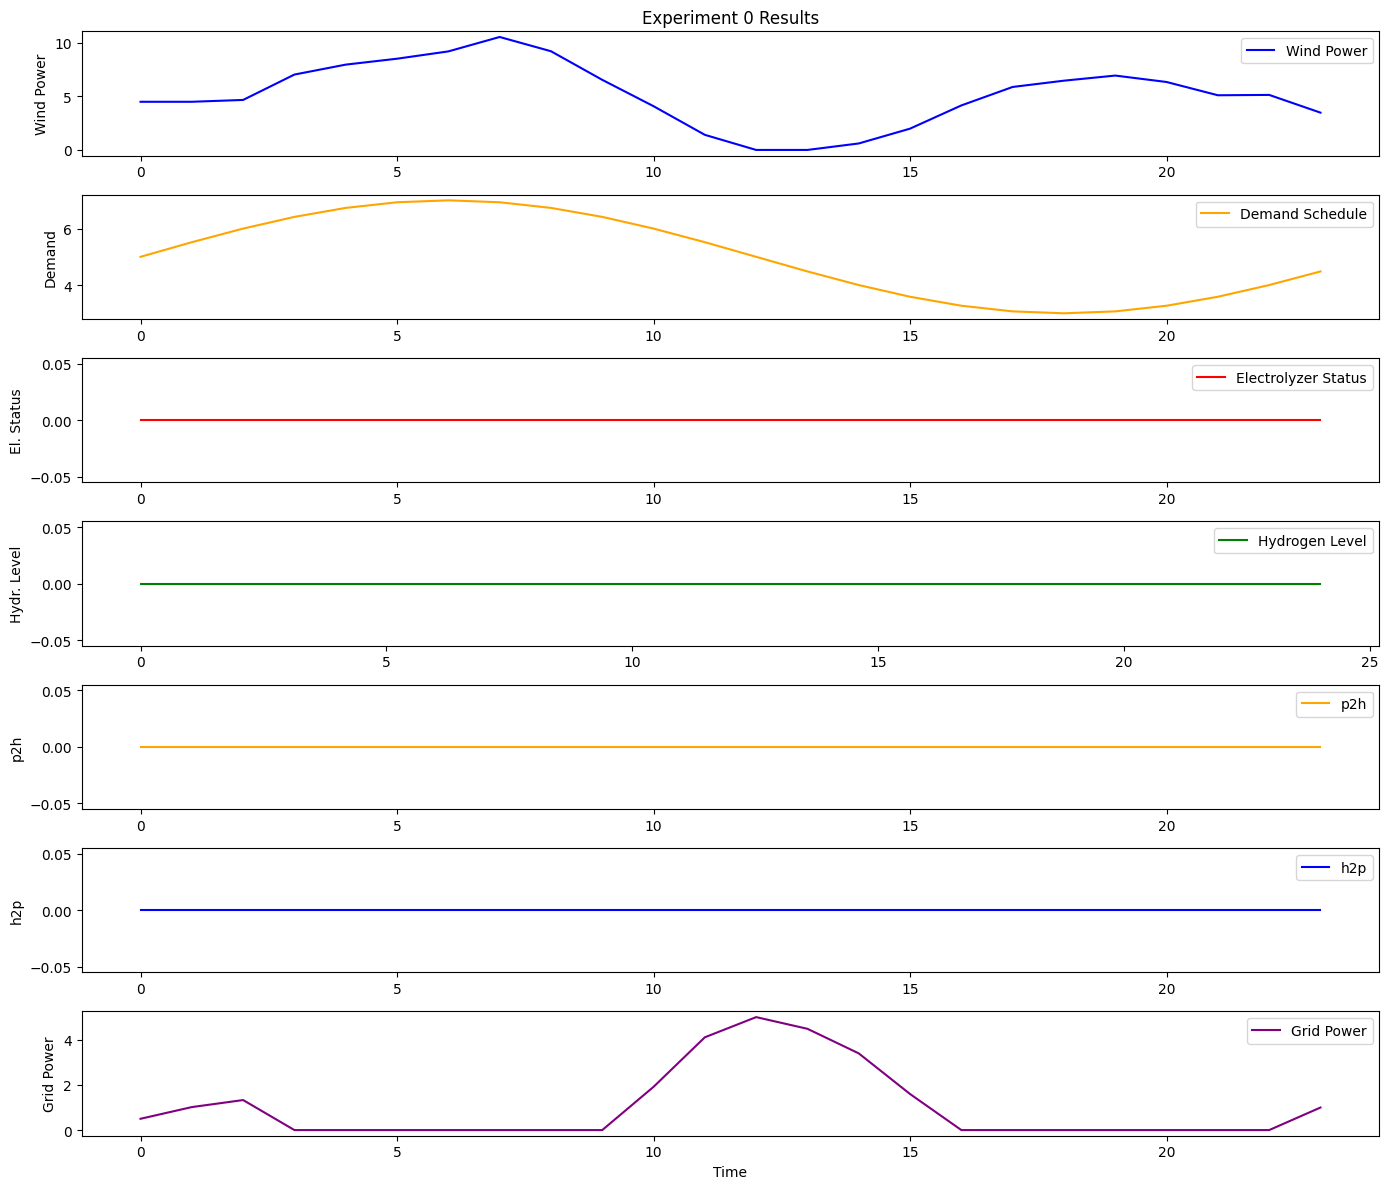

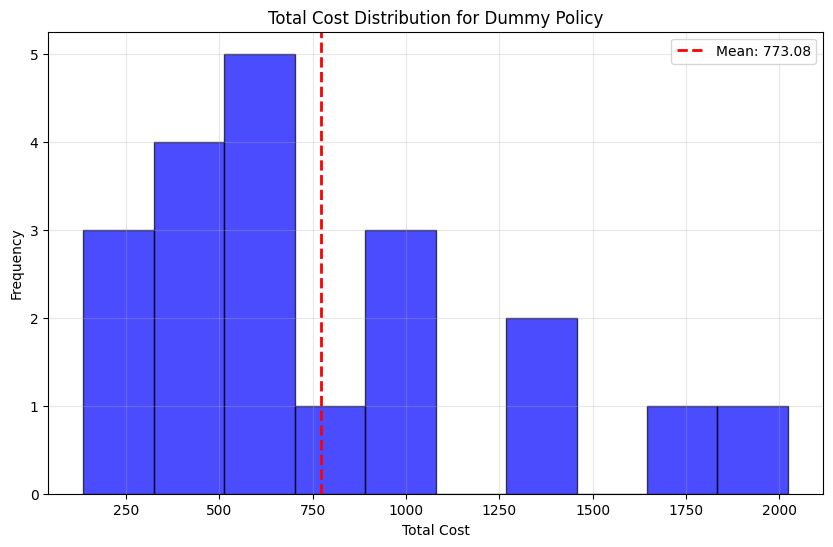


Visualizing results for ADP Policy...


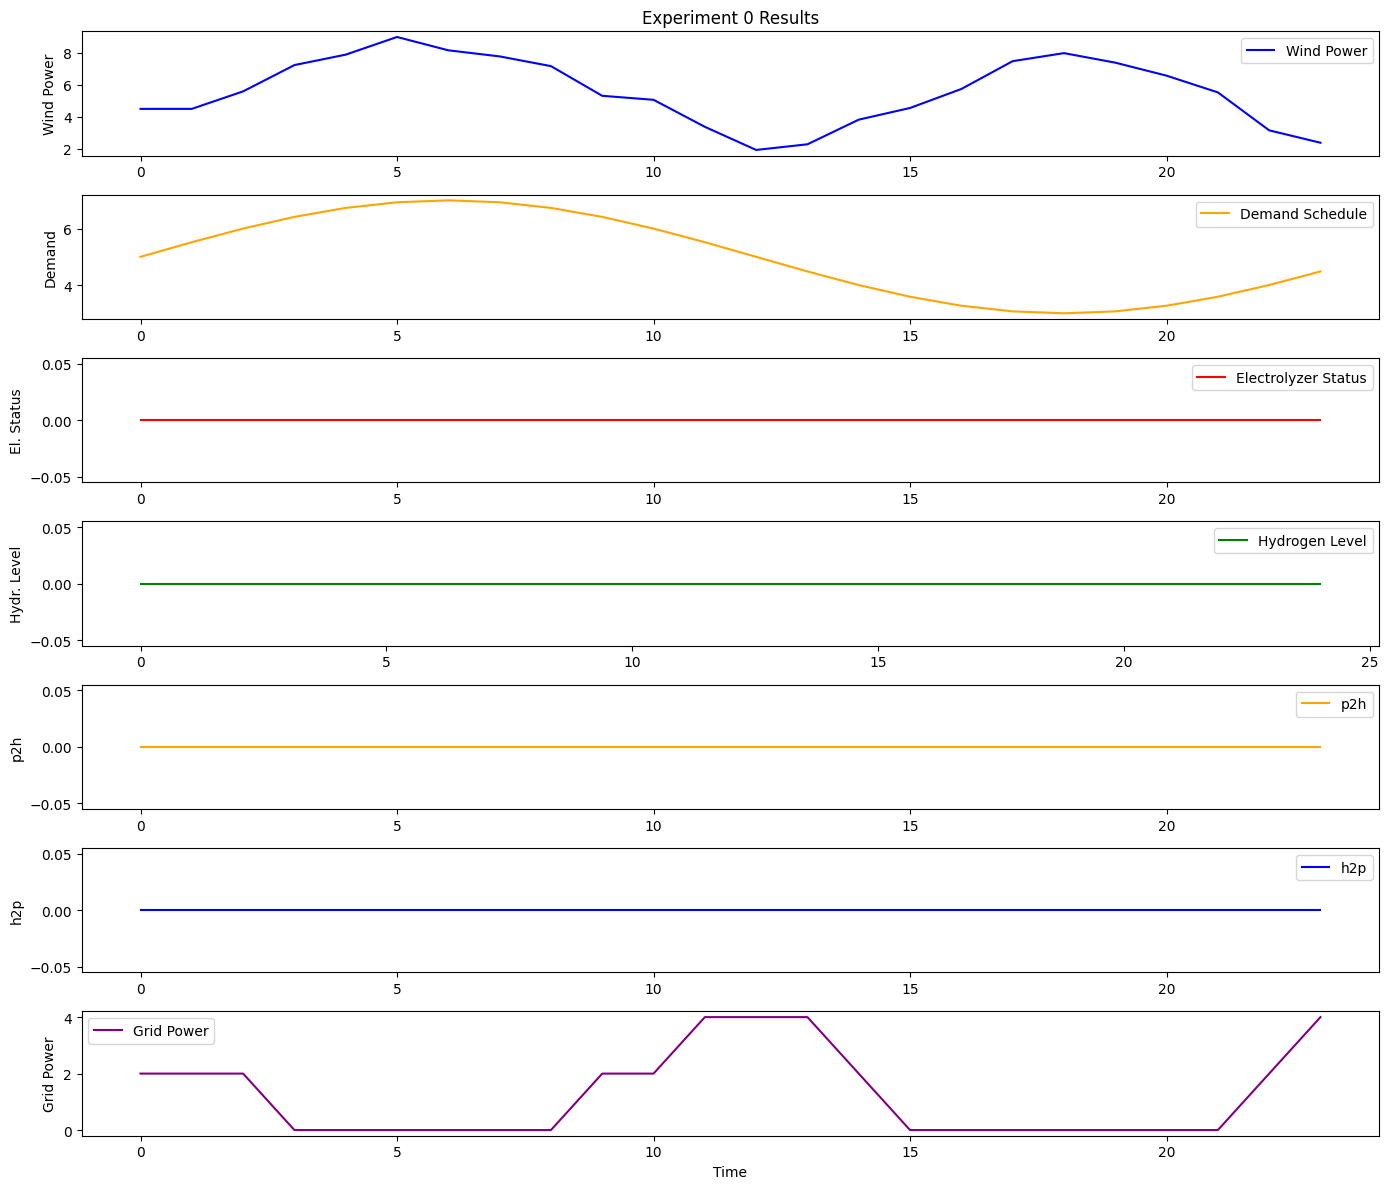

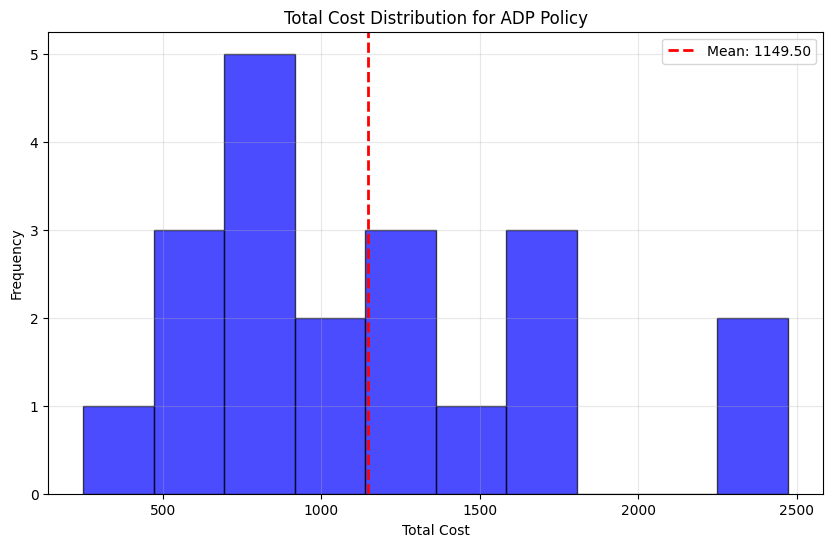


Generating comparison across all policies...


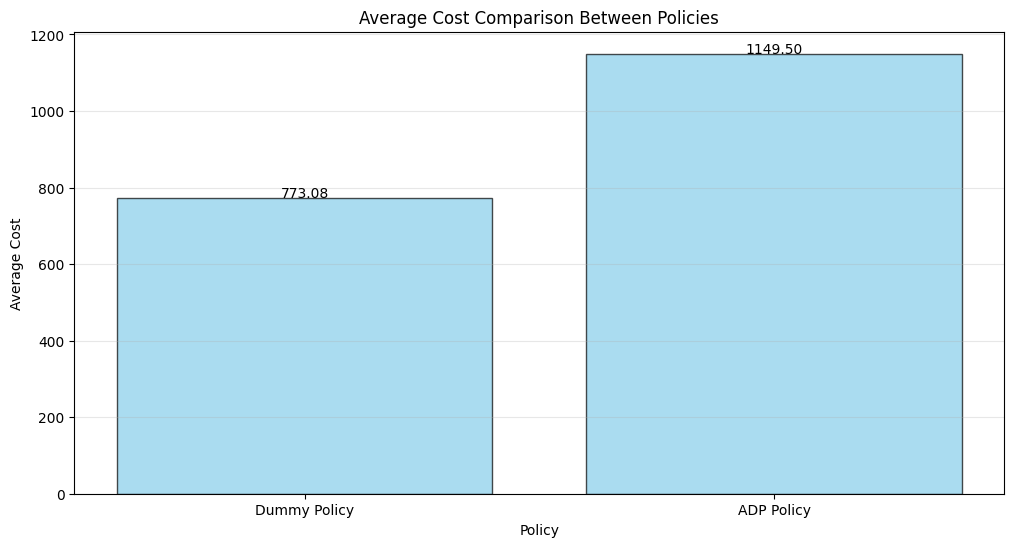


Task 3 evaluation completed successfully!


In [42]:
import numpy as np
import time

# Import required modules
from utils.data import get_fixed_data

# Import framework components
from task_1.evaluation_framework import evaluate_policy
from task_1.energy_hub_policies import dummy_policy
from task_2.helper_functions import sp_policy_long_horizon

# Import ADP implementation
from task_3.task3_6 import create_adp_policy
from utils.visualization import plot_results, plot_experiment_results, plot_cost_histogram, compare_policies

def main():
    """
    Main function to run ADP evaluation.
    """
    data = get_fixed_data()
    
    print("=" * 70)
    print("TASK 3: APPROXIMATE DYNAMIC PROGRAMMING FOR ENERGY HUB MANAGEMENT")
    print("=" * 70)
    
    # Number of experiments to run for each policy
    num_experiments = 20
    
    # Dictionary to store results for all policies
    policy_results = {}
    
    # Define the policies to evaluate
    policies = {
            "Dummy Policy": dummy_policy,
            #"SP Policy (Horizon=5, Scenarios=4)": sp_policy_long_horizon,
            "ADP Policy": create_adp_policy() 
                }
    
    # Evaluate each policy
    for policy_name, policy_func in policies.items():
        print(f"\n{'-' * 50}")
        print(f"Evaluating: {policy_name}")
        print(f"{'-' * 50}")
        
        start_time = time.time()
        
        try:
            # Run the policy evaluation
            avg_cost, results = evaluate_policy(
                policy_func,
                num_experiments=num_experiments,
                verbose=True
            )
            
            elapsed_time = time.time() - start_time
            
            # Print summary statistics
            print(f"\nResults for {policy_name}:")
            print(f"Average Cost: {avg_cost:.2f}")
            print(f"Min Cost: {np.min(results['total_costs']):.2f}")
            print(f"Max Cost: {np.max(results['total_costs']):.2f}")
            print(f"Standard Deviation: {np.std(results['total_costs']):.2f}")
            print(f"Evaluation Time: {elapsed_time:.2f} seconds")
            
            # Store the results for comparison
            policy_results[policy_name] = results
            
        except Exception as e:
            print(f"Error evaluating {policy_name}: {e}")
    
    # Generate visualizations if results are available
    if policy_results:
        print("\nGenerating visualizations...")
        
        # Generate individual policy visualizations
        for policy_name, results in policy_results.items():
            print(f"\nVisualizing results for {policy_name}...")
            
            # Plot results for a single experiment
            plot_experiment_results(results, experiment_index=0, data=data)
            
            # Plot histogram of costs across all experiments
            plot_cost_histogram(results, policy_name=policy_name)
        
        # Compare all policies if we have more than one
        if len(policy_results) > 1:
            print("\nGenerating comparison across all policies...")
            compare_policies(policy_results)
        
        print("\nTask 3 evaluation completed successfully!")
        
        # Return the results dictionary for further analysis if needed
        return policy_results
    else:
        print("\nNo policy evaluation results available.")
        return None

if __name__ == "__main__":
    main()